In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import timeit
import matplotlib.pyplot as plt
import numpy as np
import copy
import math

train_data = pd.read_csv('/content/drive/MyDrive/Colab Dataset/AI-CA3/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Dataset/AI-CA3/test.csv')

In [3]:
train_data.info()
train_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  5199 non-null   object
 1   label    5200 non-null   object
dtypes: object(2)
memory usage: 81.4+ KB


,content,label
0,فیلم‌های در حال اکران؛ موزیکال شاد خاله قورباغ...,هنر و سینما
1,پنج فیلمسازی که کوئنتین تارانتینو را عاشق سینم...,هنر و سینما
2,جانی آیو از اپل رفت جانی آیو دیگر نیازی به معر...,علم و تکنولوژی
3,احتمال عدم پشتیبانی iOS ۱۳ از آیفون ۵ اس، SE و...,علم و تکنولوژی
4,دزدان مغازه نماینده ژاپن در اسکار ۲۰۱۹ شد فیلم...,هنر و سینما


# Phase 1: Using Parsivar for Preprocessing

In [4]:
pip install parsivar

     |████████████████████████████████| 36.2 MB 330 kB/s 
     |████████████████████████████████| 1.5 MB 35.3 MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-py3-none-any.whl size=36492972 sha256=c986aa2689873677b96a6feb5092f558290c40678b352d74cf42e27f2c968287
  Stored in directory: /root/.cache/pip/wheels/ae/67/7a/49cbf08f64d3f76a26eceaf0e481a40e233f05d4356875cbed
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449920 sha256=b579d42e9ab664609487285ca19c6f26ef273c60098e6bc877cdbcf6c2211d52
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built parsivar nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [5]:
file = open('/content/drive/MyDrive/Colab Dataset/AI-CA3/stop words.txt', 'r')
stop_words = file.read().splitlines()
file_ = open('/content/drive/MyDrive/Colab Dataset/AI-CA3/some words to delete.txt', 'r')
some_words_to_delete = file_.read().splitlines()

#parsivar
from parsivar import Normalizer
my_normalizer = Normalizer(statistical_space_correction=True)
from parsivar import FindStems
my_stemmer = FindStems()
from parsivar import Tokenizer
my_tokenizer = Tokenizer()

def normalize_text(text):
  words = my_tokenizer.tokenize_words(my_normalizer.normalize(text))
  words_without_sw = [word for word in words if not word in stop_words]
  for i in range(len(words_without_sw)):
     words_without_sw[i] = my_stemmer.convert_to_stem(words_without_sw[i])
  words_without_sw = [word for word in words_without_sw if not word in some_words_to_delete]
  return words_without_sw

#### Normalizing Datas

In [6]:
train_file = train_data.copy(deep=True)
train_file = train_file.dropna()
test_file = test_data.copy(deep=True)
test_file = test_file.dropna()

train_file['content'] = [normalize_text(data) for data in train_file['content']]
test_file['content'] = [normalize_text(data) for data in test_file['content']]

In [7]:
temp_train = train_file.copy(deep=True)
temp_test = test_file.copy(deep=True)
temp_train.head(5)

,content,label
0,"[فیلم, اکران, موزیکال, شاد, خاله, قورباغه, بزر...",هنر و سینما
1,"[فیلمسازی, کوئنتین‌تارانتینو, عاشق, سینما, کمت...",هنر و سینما
2,"[جانی, آیو, اپل, رفت‌جانی, آیو, نیازی, معرفی, ...",علم و تکنولوژی
3,"[احتمال, پشتیبانی, iOS, 13, آیفون‌5, اس, SE‌و,...",علم و تکنولوژی
4,"[دزد, مغازه, نماینده, ژاپن, اسکار, 2019, فیلم,...",هنر و سینما


# Phase 2
#### Counting num of words

In [115]:
tech_words = []
art_words = []
game_words = []
health_words = []

tech_df = temp_train.loc[temp_train['label'] == 'علم و تکنولوژی']
art_df = temp_train.loc[temp_train['label'] == 'هنر و سینما']
game_df = temp_train.loc[temp_train['label'] == 'بازی ویدیویی']
health_df = temp_train.loc[temp_train['label'] == 'سلامت و زیبایی']
for content in tech_df['content']:
  tech_words += content
for content in art_df['content']:
  art_words += content
for content in game_df['content']:
  game_words += content
for content in health_df['content']:
  health_words += content

all_words = tech_words + art_words + game_words + health_words
set_of_all_words = set()
for word in all_words:
  set_of_all_words.add(word)

#making dictionary along with the number of occurrences
tech_dict = {}
art_dict = {}
game_dict = {}
health_dict = {}

def make_dict(list_of_words, dict):
  for word in list_of_words:
    if word in dict:
        dict[word] += 1
    else:
        dict[word] = 1
  for word in set_of_all_words:
    if word not in dict:
      dict[word] = 0
  #Additive Smoothing
  alpha = 5
  for word in dict:
    dict[word] += alpha

make_dict(tech_words, tech_dict)
make_dict(art_words, art_dict)
make_dict(game_words, game_dict)
make_dict(health_words, health_dict)

tech_dict_for_plot = copy.deepcopy(tech_dict)
art_dict_for_plot = copy.deepcopy(art_dict)
game_dict_for_plot = copy.deepcopy(game_dict)
health_dict_for_plot = copy.deepcopy(health_dict)

#### Calculating Probabilities

In [116]:
def calculate_probability(dict):
  words_num = 0
  for word in dict:
    words_num += dict[word]
  for word in dict:
    dict[word] = dict[word]/words_num

calculate_probability(tech_dict)
calculate_probability(art_dict)
calculate_probability(game_dict)
calculate_probability(health_dict)

In [117]:
def calculate_class_prob(text, dict, df):
  prob = df.shape[0]/train_file.shape[0]
  for word in text:
    if word in dict:
      if dict[word] == 0:
        prob *= dict[word]
      else:
        prob *= abs(math.log(dict[word], 5000))
      # print(prob)
  if prob == 0:
    return -float('inf') 
  else:
    return -1*prob

def find_the_class(text):
  if isinstance(text, str):
    text = normalize_text(text)
  tech_prob = calculate_class_prob(text, tech_dict, tech_df)
  art_prob = calculate_class_prob(text, art_dict, art_df)
  game_prob = calculate_class_prob(text, game_dict, game_df)
  health_prob = calculate_class_prob(text, health_dict, health_df)
  decision_dict = {
    'tech': tech_prob,
    'art': art_prob,
    'game': game_prob,
    'health': health_prob
  }
  # print(decision_dict)
  ans = 'tech'
  ans_prob = decision_dict['tech']
  for class_ in decision_dict:
    if decision_dict[class_] > ans_prob:
      ans = class_
      ans_prob = decision_dict[class_]
  
  return ans

In [118]:
#Test
text = '!آرامش روان خیلی خیلی مهم است'
print('Text Class:' , find_the_class(text))

Text Class: health


#### Bar Plot for most repeated words in each class

In [119]:
pip install python-bidi

In [120]:
pip install --upgrade arabic-reshaper

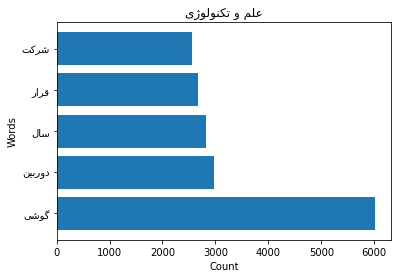

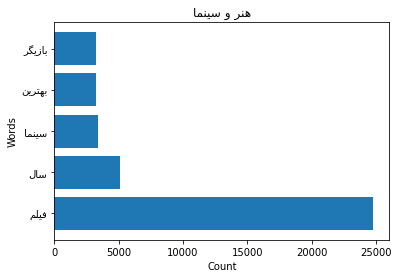

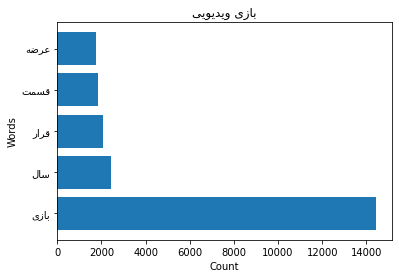

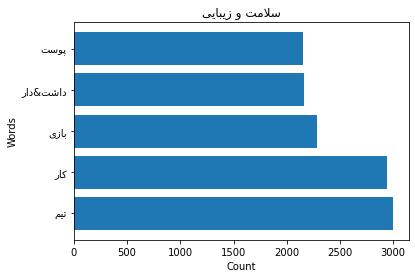

In [121]:
import arabic_reshaper
from bidi.algorithm import get_display

tech_top = sorted(tech_dict, key=tech_dict.get, reverse=True)[:5]
art_top = sorted(art_dict, key=art_dict.get, reverse=True)[:5]
game_top = sorted(game_dict, key=game_dict.get, reverse=True)[:5]
health_top = sorted(health_dict, key=health_dict.get, reverse=True)[:5]
def make_class_num(dict, class_top):
  num_list = []
  for word in class_top:
    num_list.append(dict[word])
  return num_list

tech_num_list = make_class_num(tech_dict_for_plot, tech_top)
art_num_list = make_class_num(art_dict_for_plot, art_top)
game_num_list = make_class_num(game_dict_for_plot, game_top)
health_num_list = make_class_num(health_dict_for_plot, health_top)

#function for barplot
def barplot(x,y,title):
  for i in range(len(x)):
    x[i] = get_display(arabic_reshaper.reshape(x[i]))
  plt.barh(x, y)
  plt.title(get_display(arabic_reshaper.reshape(title)))
  plt.xlabel('Count')
  plt.ylabel('Words')
  plt.show()

#plot
barplot(tech_top, tech_num_list, 'علم و تکنولوژِی')
barplot(art_top, art_num_list, 'هنر و سینما')
barplot(game_top, game_num_list, 'بازی ویدیویی')
barplot(health_top, health_num_list, 'سلامت و زیبایی')

# Phase 3

### Accuracy

In [122]:
correct_detected = 0
for i in range(test_file.shape[0]):
  ans = find_the_class(test_file['content'][i])
  if ans == 'tech':
    ans = 'علم و تکنولوژی'
  elif ans == 'art':
    ans = 'هنر و سینما'
  elif ans == 'game':
    ans = 'بازی ویدیویی'
  elif ans == 'health':
    ans = 'سلامت و زیبایی'

  if ans == test_file['label'][i]:
    correct_detected += 1
accuracy = correct_detected/test_file.shape[0]*100
print('Accuracy:', accuracy, '%')

Accuracy: 95.01246882793018 %


### Recall

In [123]:
def calculate_recall(e_title, label):
  correct_detected = 0
  my_test = test_file.loc[test_file['label'] == label]
  for content in my_test['content']:
    ans = find_the_class(content)
    if ans == e_title:
      correct_detected += 1
  Recall = correct_detected/my_test.shape[0]*100
  print(e_title,'recall:', Recall, '%')
  return Recall

In [124]:
#tech
label = "علم و تکنولوژی"
tech_recall = calculate_recall('tech', label)
#art
label = "هنر و سینما"
art_recall = calculate_recall('art', label)
#game
label = "بازی ویدیویی"
game_recall = calculate_recall('game', label)
#health
label = "سلامت و زیبایی"
health_recall = calculate_recall('health', label)

tech recall: 95.66787003610109 %
art recall: 99.40119760479041 %
game recall: 88.83248730964468 %
health recall: 96.8944099378882 %


### Precision

In [125]:
def calculate_precision(e_title, label):
  correct_detected = 0
  my_test = test_file.loc[test_file['label'] == label]
  for content in my_test['content']:
    ans = find_the_class(content)
    if ans == e_title:
      correct_detected += 1
      
  all_detected_class = 0
  for i in range(test_file.shape[0]):
    ans = find_the_class(test_file['content'][i])
    if ans == e_title:
      all_detected_class += 1
  Precision = correct_detected/all_detected_class*100
  print(e_title,'precision:', Precision, '%')
  return Precision

In [126]:
#tech
label = "علم و تکنولوژی"
tech_precision = calculate_precision('tech', label)
#art
label = "هنر و سینما"
art_precision = calculate_precision('art', label)
#game
label = "بازی ویدیویی"
game_precision = calculate_precision('game', label)
#health
label = "سلامت و زیبایی"
health_precision = calculate_precision('health', label)

tech precision: 95.32374100719424 %
art precision: 91.71270718232044 %
game precision: 99.43181818181817 %
health precision: 93.41317365269461 %


### F1-Score

In [127]:
tech_f1 = 2*tech_recall*tech_precision/(tech_recall+tech_precision)
print('tech F1:', tech_f1, '%')
art_f1 = 2*art_recall*art_precision/(art_recall+art_precision)
print('art F1:', art_f1, '%')
game_f1 = 2*game_recall*game_precision/(game_recall+game_precision)
print('game F1:', game_f1, '%')
health_f1 = 2*health_recall*health_precision/(health_recall+health_precision)
print('health F1:', health_f1, '%')

tech F1: 95.49549549549549 %
art F1: 95.40229885057471 %
game F1: 93.83378016085791 %
health F1: 95.1219512195122 %


### F1-Macro-Average

In [128]:
f1_macro_average = (tech_f1 + art_f1 + game_f1 + health_f1)/4
print('F1 Macro Average:', f1_macro_average, '%')

F1 Macro Average: 94.96338143161009 %


### F1-Micro-Average

In [129]:
#Recall micro average
correct_detected = 0
# my_test = test_file.loc[test_file['label'] == label]
for i in range(test_file.shape[0]):
  ans = find_the_class(test_file['content'][i])
  if ans == 'tech':
    ans = 'علم و تکنولوژی'
  elif ans == 'art':
    ans = 'هنر و سینما'
  elif ans == 'game':
    ans = 'بازی ویدیویی'
  elif ans == 'health':
    ans = 'سلامت و زیبایی'
  if ans == test_file['label'][i]:
    correct_detected += 1
recall_micro_average = correct_detected/test_file.shape[0]*100

#Precision micro average
correct_detected = 0
for i in range(test_file.shape[0]):
  ans = find_the_class(test_file['content'][i])
  if ans == 'tech':
    ans = 'علم و تکنولوژی'
  elif ans == 'art':
    ans = 'هنر و سینما'
  elif ans == 'game':
    ans = 'بازی ویدیویی'
  elif ans == 'health':
    ans = 'سلامت و زیبایی'
  if ans == test_file['label'][i]:
    correct_detected += 1
precision_micro_average = correct_detected/test_file.shape[0]*100

#F1 micro average
f1_micro_average = 2*recall_micro_average*precision_micro_average/(recall_micro_average+precision_micro_average)
print('F1 Micro Average:', f1_micro_average, '%')

F1 Micro Average: 95.01246882793016 %


### Weighted-Average

In [130]:
#counting num of samples in each class
tech_num = 0
art_num = 0
game_num = 0
health_num = 0
for label in test_file['label']:
  if label == 'علم و تکنولوژی':
    tech_num += 1 
  elif label == 'هنر و سینما':
    art_num += 1
  elif label == 'بازی ویدیویی':
    game_num += 1
  elif label == 'سلامت و زیبایی':
    health_num += 1
f1_weighter_average = (tech_f1*tech_num + art_f1*art_num + game_f1*game_num + health_f1*health_num)/(tech_num+art_num+game_num+health_num)
print('F1 Weighted Average:', f1_weighter_average, '%')

F1 Weighted Average: 94.9929239380657 %


### Five Articles that Detected Wrongly

In [148]:
with open('five wrong detected articles.txt', 'w') as f:
  count = 0
  for i in range(test_file.shape[0]):
    ans = find_the_class(test_file['content'][i])
    if ans == 'tech':
      ans = 'علم و تکنولوژی'
    elif ans == 'art':
      ans = 'هنر و سینما'
    elif ans == 'game':
      ans = 'بازی ویدیویی'
    elif ans == 'health':
      ans = 'سلامت و زیبایی'
    if ans != test_file['label'][i]:
      count += 1
      f.write(test_data['content'][i])
      f.write('\n')
      f.write('\n')
      print('Article', count, ':', '( real class:',test_file['label'][i], ' detected class:', ans, ')')
      print(test_data['content'][i])
    if count == 5:
      break

Article 1 : ( real class: بازی ویدیویی  detected class: هنر و سینما )
سریال Devil May Cry ساخته می‌شود طبق گزارش وب‌سایت IGN، سریال انیمیشنی دویل می‌کرای (Devil May Cry) در دست ساخت قرار دارد‌ این مجموعه توسط تهیه‌کننده سریال کسلوانیا یعنی ادی شنکار (Adi Shankar) ساخته می‌شود. طبق گفته شنکار، هر دوی این مجموعه‌ها در یک دنیای مشترک تلویزیونی با نام جریان دارند. هنوز هیچ چیزی درباره زمان پخش سریال Devil May Cry و افراد سازنده آن، یا حتی شبکه‌ای که قرار است آن را پخش کند، نمی‌دانیم. هنوز هیچ چیزی درباره زمان پخش سریال Devil May Cry نمی‌دانیم. شنکار در ادامه صحبت‌های خود اعلام کرد که موفقیت سریال کسلوانیا به ساخت سریال‌های جدید کمک کرده است. فصل دوم سریال کسلوانیا چند وقت پیش بر روی شبکه نت‌فلیکس منتشر شد و توانست عملکرد بی‌نظیری از خود نشان دهد. در واقع استقبال هواداران از این مجموعه به حدی خوب بود که ساخت فصل سوم آن بلافاصله تایید شد. داستان این سریال توسط وارن الیس نوشته شده است؛ او پیش از این روی کمیک‌ها و رمان‌هایی مثل Transmetropolitan و The Authority کار کرده بود. سری Devil May Cry 